In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import os
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
import opendatasets as od

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import random
from pathlib import Path

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPool2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

import cv2

from skimage.io import imread
from skimage.transform import resize

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

from PIL import Image
import imgaug as aug
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import matplotlib.image as mimg
%matplotlib inline
import seaborn as sns
import plotly.express as px

In [ ]:
od.download("https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: vijaypatidar30
Your Kaggle Key: ··········


100%|██████████| 2.29G/2.29G [01:53<00:00, 21.7MB/s]


In [ ]:
base_dir = Path("chest-xray-pneumonia/chest_xray/chest_xray/")
train_dir = base_dir /"train/"
val_dir = base_dir /"val/"
test_dir = base_dir /"test/"

In [ ]:
tf.__version__

'2.12.0'

In [ ]:
%tensorflow_version 2.12
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


In [ ]:
os.listdir(train_dir)

['.DS_Store', 'NORMAL', 'PNEUMONIA']

In [ ]:
train_normal_dir = train_dir /"NORMAL"
train_pneumonia_dir = train_dir /"PNEUMONIA"

In [ ]:
os.listdir(val_dir)

['.DS_Store', 'NORMAL', 'PNEUMONIA']

In [ ]:
valid_normal_dir = val_dir /"NORMAL"
valid_pneumonia_dir = val_dir /"PNEUMONIA"

In [ ]:
os.listdir(test_dir)

['.DS_Store', 'NORMAL', 'PNEUMONIA']

In [ ]:
test_normal_dir = test_dir /"NORMAL"
test_pneumonia_dir = test_dir /"PNEUMONIA"

In [ ]:
train_normal= train_normal_dir.glob("*.jpeg")
train_pneumonia=train_pneumonia_dir.glob("*.jpeg")
train_set=[]

In [ ]:
for img in train_normal:
  train_set.append((img, 0))
for img in train_pneumonia:
  train_set.append((img, 1))

In [ ]:
train_set=pd.DataFrame(train_set, columns=["image", "label"], index=None)

In [ ]:
train_set.head()

image  label
0  chest-xray-pneumonia/chest_xray/chest_xray/tra...      0
1  chest-xray-pneumonia/chest_xray/chest_xray/tra...      0
2  chest-xray-pneumonia/chest_xray/chest_xray/tra...      0
3  chest-xray-pneumonia/chest_xray/chest_xray/tra...      0
4  chest-xray-pneumonia/chest_xray/chest_xray/tra...      0

In [ ]:
print(train_set[:15])

                                                image  label
0   chest-xray-pneumonia/chest_xray/chest_xray/tra...      0
1   chest-xray-pneumonia/chest_xray/chest_xray/tra...      0
2   chest-xray-pneumonia/chest_xray/chest_xray/tra...      0
3   chest-xray-pneumonia/chest_xray/chest_xray/tra...      0
4   chest-xray-pneumonia/chest_xray/chest_xray/tra...      0
5   chest-xray-pneumonia/chest_xray/chest_xray/tra...      0
6   chest-xray-pneumonia/chest_xray/chest_xray/tra...      0
7   chest-xray-pneumonia/chest_xray/chest_xray/tra...      0
8   chest-xray-pneumonia/chest_xray/chest_xray/tra...      0
9   chest-xray-pneumonia/chest_xray/chest_xray/tra...      0
10  chest-xray-pneumonia/chest_xray/chest_xray/tra...      0
11  chest-xray-pneumonia/chest_xray/chest_xray/tra...      0
12  chest-xray-pneumonia/chest_xray/chest_xray/tra...      0
13  chest-xray-pneumonia/chest_xray/chest_xray/tra...      0
14  chest-xray-pneumonia/chest_xray/chest_xray/tra...      0


In [ ]:
train_set=train_set.sample(frac=1)
train_set=train_set.reset_index(drop=True)
train_set.head()

image  label
0  chest-xray-pneumonia/chest_xray/chest_xray/tra...      1
1  chest-xray-pneumonia/chest_xray/chest_xray/tra...      0
2  chest-xray-pneumonia/chest_xray/chest_xray/tra...      1
3  chest-xray-pneumonia/chest_xray/chest_xray/tra...      1
4  chest-xray-pneumonia/chest_xray/chest_xray/tra...      1

In [ ]:
valid_normal= valid_normal_dir.glob("*.jpeg")
valid_pneumonia=valid_pneumonia_dir.glob("*.jpeg")
valid_set=[]

In [ ]:
for img in valid_normal:
  valid_set.append((img, 0))
for img in valid_pneumonia:
  valid_set.append((img, 1))

In [ ]:
print(valid_set[:15])

[(PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1438-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1436-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1440-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1430-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1437-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1442-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1431-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg'), 1), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1950_bacteria_4881.jpeg'),

In [ ]:
valid_set=pd.DataFrame(valid_set, columns=["image", "label"], index=None)
valid_set.head()

image  label
0  chest-xray-pneumonia/chest_xray/chest_xray/val...      0
1  chest-xray-pneumonia/chest_xray/chest_xray/val...      0
2  chest-xray-pneumonia/chest_xray/chest_xray/val...      0
3  chest-xray-pneumonia/chest_xray/chest_xray/val...      0
4  chest-xray-pneumonia/chest_xray/chest_xray/val...      0

In [ ]:
valid_set=valid_set.sample(frac=1)
valid_set=valid_set.reset_index(drop=True)
valid_set.head()

image  label
0  chest-xray-pneumonia/chest_xray/chest_xray/val...      1
1  chest-xray-pneumonia/chest_xray/chest_xray/val...      1
2  chest-xray-pneumonia/chest_xray/chest_xray/val...      1
3  chest-xray-pneumonia/chest_xray/chest_xray/val...      1
4  chest-xray-pneumonia/chest_xray/chest_xray/val...      0

In [ ]:
test_normal= test_normal_dir.glob("*.jpeg")
test_pneumonia=test_pneumonia_dir.glob("*.jpeg")
test_set=[]

In [ ]:
for img in test_normal:
  test_set.append((img, 0))
for img in test_pneumonia:
  test_set.append((img, 1))

In [ ]:
print(test_set[:15])

[(PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/IM-0011-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/IM-0087-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0327-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0340-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0246-0001-0002.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0273-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/IM-0095-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0132-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/IM-0069-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0289-0001.jpeg'), 0), (PosixPath('chest-xray-pne

In [ ]:
test_set=pd.DataFrame(test_set, columns=["image", "label"], index=None)
test_set.head()

image  label
0  chest-xray-pneumonia/chest_xray/chest_xray/tes...      0
1  chest-xray-pneumonia/chest_xray/chest_xray/tes...      0
2  chest-xray-pneumonia/chest_xray/chest_xray/tes...      0
3  chest-xray-pneumonia/chest_xray/chest_xray/tes...      0
4  chest-xray-pneumonia/chest_xray/chest_xray/tes...      0

In [ ]:
test_set=test_set.sample(frac=1)
test_set=test_set.reset_index(drop=True)
test_set.head()

image  label
0  chest-xray-pneumonia/chest_xray/chest_xray/tes...      0
1  chest-xray-pneumonia/chest_xray/chest_xray/tes...      0
2  chest-xray-pneumonia/chest_xray/chest_xray/tes...      1
3  chest-xray-pneumonia/chest_xray/chest_xray/tes...      1
4  chest-xray-pneumonia/chest_xray/chest_xray/tes...      0

In [ ]:
train_normal_count= train_set.loc[train_set["label"]==0]["image"].count()
print("Total number of normal images:", train_normal_count)

Total number of normal images: 1341


In [ ]:
train_pneumonia_count= train_set.loc[train_set["label"]==1]["image"].count()
print("Total number of pneumonia images:", train_pneumonia_count)

Total number of pneumonia images: 3875


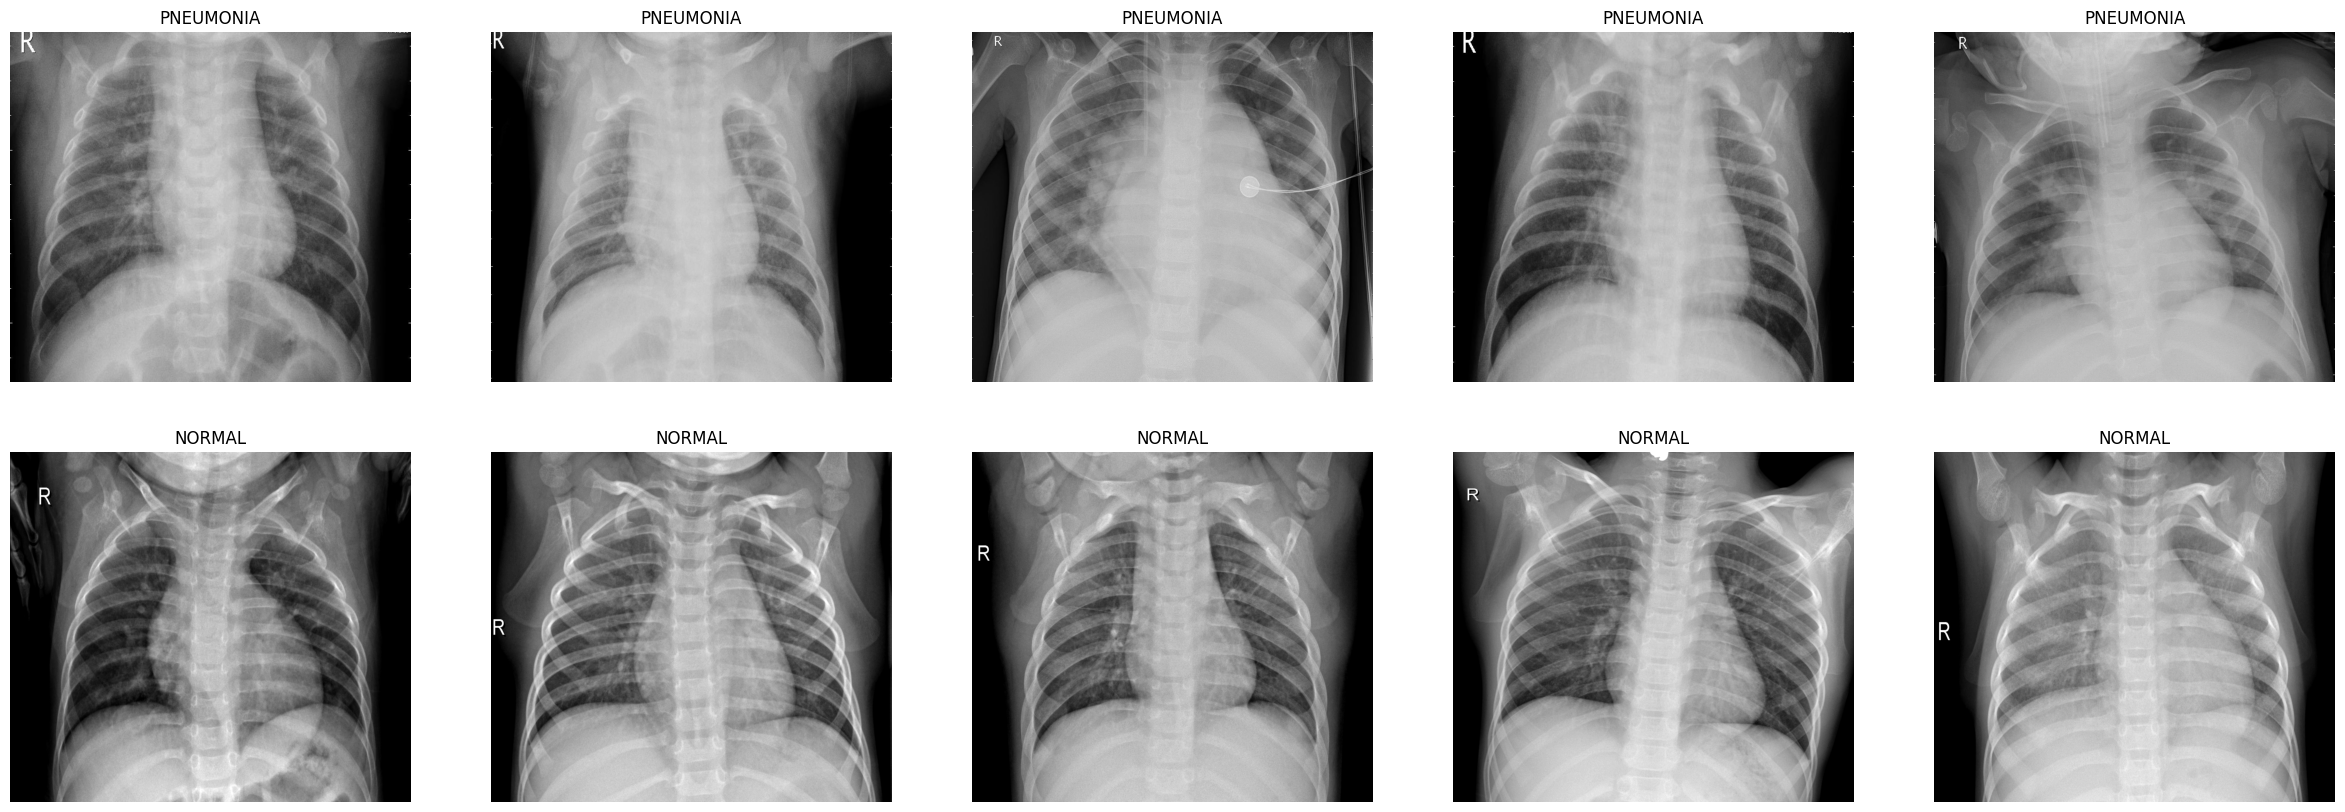

In [ ]:
pneumonia_samples = (train_set[train_set["label"] == 1]["image"].iloc[:5]).tolist()
normal_samples = (train_set[train_set["label"] == 0]["image"].iloc[:5]).tolist()

samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples
f, ax = plt.subplots(2,5, figsize = (30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i % 5].imshow(img, cmap='gray')
    if i < 5:
        ax[i//5, i % 5].set_title("PNEUMONIA")
    else:
        ax[i//5, i % 5].set_title("NORMAL")
    ax[i//5, i % 5].axis('off')
    ax[i//5, i % 5].set_aspect('auto')
plt.show()

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
import os

def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            if img.endswith('.DS_Store'):
                continue
            try:
                file_name, extension = os.path.splitext(img)
                if extension.lower() not in ['.jpg', '.png', '.jpeg']:
                    print(f"Skipping non-image file: {os.path.join(path, img)}")
                    continue
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)


In [ ]:
train = get_training_data(train_dir)
test = get_training_data(test_dir)
val = get_training_data(val_dir)

In [ ]:
X_train, X_val, X_test = ([], ) * 3
y_train, y_val, y_test = ([], ) * 3

for feature, label in train:
    X_train.append(feature)
    y_train.append(label)

for feature, label in val:
    X_val.append(feature)
    y_val.append(label)

for feature, label in test:
    X_test.append(feature)
    y_test.append(label)

In [ ]:
X_train = np.array(X_train) /255
X_val = np.array(X_val) / 255
X_test = np.array(X_test) / 255

In [ ]:
X_train = X_train.reshape (-1, img_size, img_size, 1)
y_train = np.array(y_train)

X_val = X_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

X_test = X_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [ ]:
image_generator = ImageDataGenerator(
  featurewise_center = False, # set input mean to 0 over the dataset
  samplewise_center = False, # set each sample mean to 0
  featurewise_std_normalization = False, #divide inputs by std of the dataset
  samplewise_std_normalization = False, # divide each input by its std
  zca_whitening=False,  # apply ZCA whitening
  rotation_range =30, #randomly rotate images in the range
  zoom_range = 0.2, #randomly zoom image
  width_shift_range = 0.1, #randomly shift images horizontally
  height_shift_range = 0.1, #randomly shift images vertically
  horizontal_flip = True, #randomly flip images
  vertical_flip = False) #randomly flip images

image_generator.fit(X_train)

In [ ]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=0.000001)

In [ ]:
history = model.fit(image_generator.flow(X_train, y_train, batch_size=32), epochs=15, validation_data=image_generator.flow(X_val, y_val), callbacks=[learning_rate_reduction])

Epoch 1/15
183/183 [==============================] - 50s 138ms/step - loss: 0.5154 - accuracy: 0.8268 - val_loss: 8.6686 - val_accuracy: 0.7297 - lr: 0.0010
Epoch 2/15
183/183 [==============================] - 25s 137ms/step - loss: 0.2779 - accuracy: 0.8991 - val_loss: 15.4884 - val_accuracy: 0.7297 - lr: 0.0010
Epoch 3/15
183/183 [==============================] - 25s 136ms/step - loss: 0.2350 - accuracy: 0.9173 - val_loss: 3.0971 - val_accuracy: 0.7502 - lr: 0.0010
Epoch 4/15
183/183 [==============================] - 25s 136ms/step - loss: 0.2310 - accuracy: 0.9245 - val_loss: 0.3071 - val_accuracy: 0.8591 - lr: 0.0010
Epoch 5/15
183/183 [==============================] - 25s 136ms/step - loss: 0.2060 - accuracy: 0.9274 - val_loss: 0.2062 - val_accuracy: 0.9349 - lr: 0.0010
Epoch 6/15
183/183 [==============================] - 35s 190ms/step - loss: 0.1992 - accuracy: 0.9319 - val_loss: 1.2346 - val_accuracy: 0.6713 - lr: 0.0010
Epoch 7/15
183/183 [==============================]

In [ ]:
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

183/183 [==============================] - 2s 10ms/step - loss: 0.1420 - accuracy: 0.9522
Loss of the model is -  0.14197371900081635
183/183 [==============================] - 2s 10ms/step - loss: 0.1420 - accuracy: 0.9522
Accuracy of the model is -  95.21858096122742 %


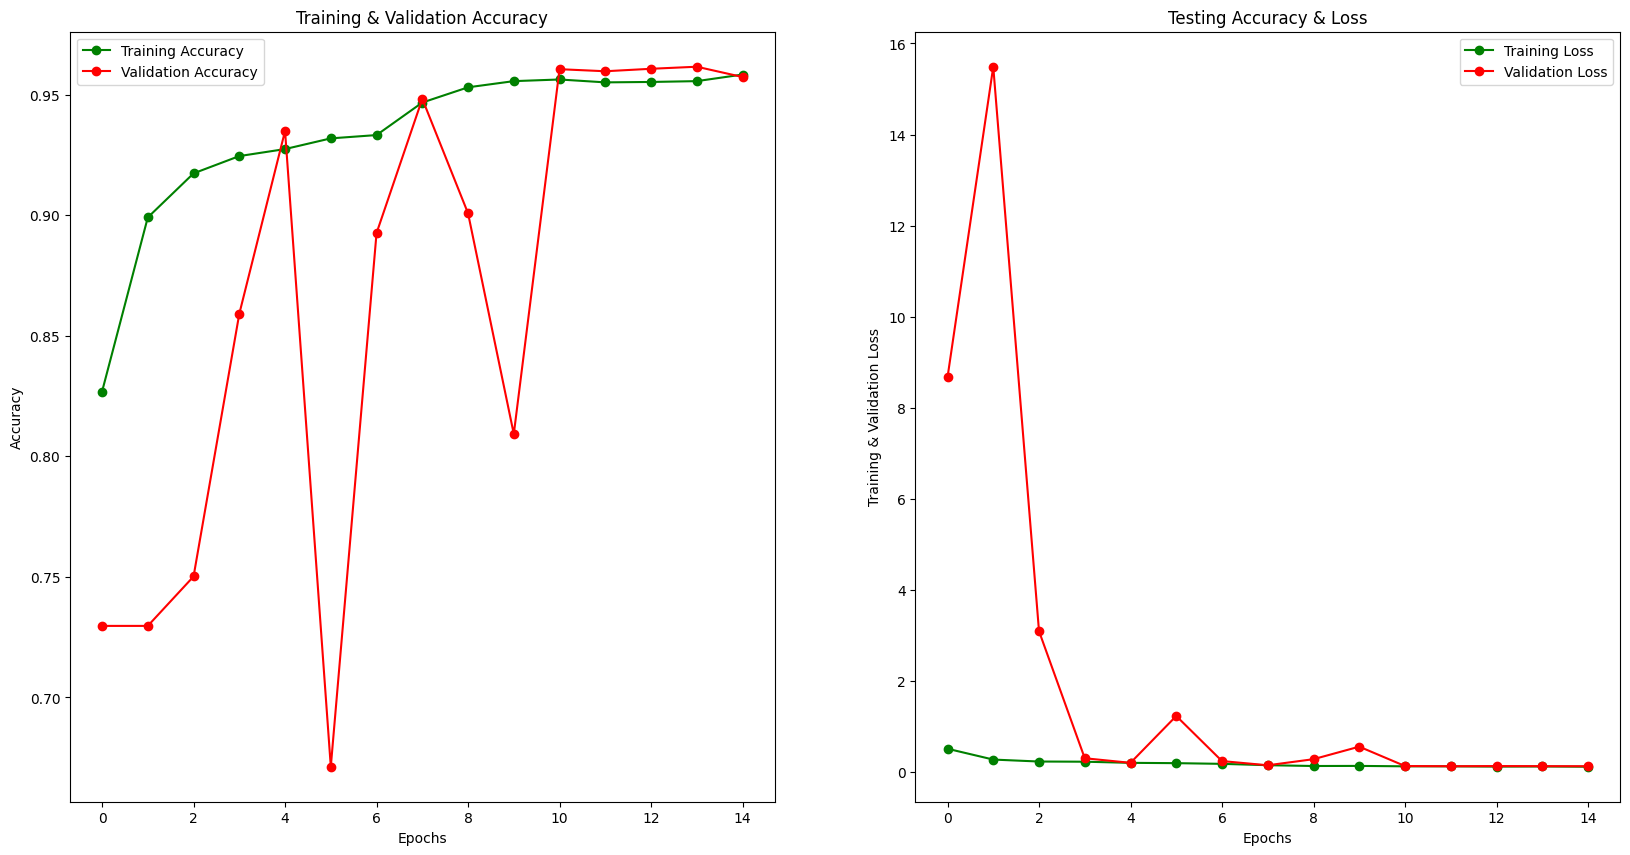

In [ ]:
epochs = [i for i in range(15)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
predictions = (model.predict(X_test) > 0.5).astype("int32")
predictions = predictions.reshape(1, -1)[0]
predictions[:15]

183/183 [==============================] - 2s 8ms/step


array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.98      0.95      0.97      4273
   Normal (Class 1)       0.88      0.96      0.92      1583

           accuracy                           0.95      5856
          macro avg       0.93      0.95      0.94      5856
       weighted avg       0.96      0.95      0.95      5856



In [ ]:
cm = confusion_matrix(y_test, predictions)
cm

array([[4057,  216],
       [  64, 1519]])

In [ ]:
cm = pd.DataFrame(cm, index=['0', '1'], columns=['0', '1'])

<Axes: >

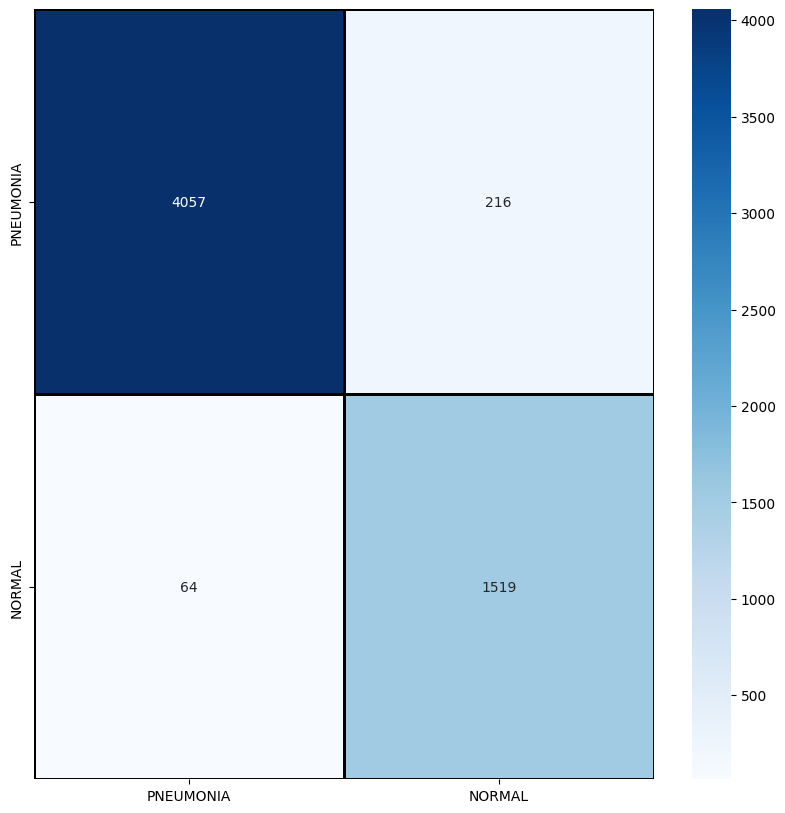

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [ ]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

<ipython-input-53-194eb1c1c186>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 2, i+1)


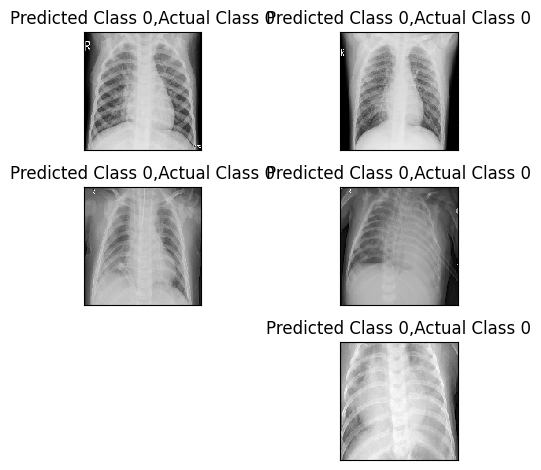

In [ ]:
i = 0
for c in correct[:6]:
    plt.subplot(3, 2, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[c].reshape(150, 150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(
        predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

<ipython-input-54-b9cc46b9bc85>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 2, i+1)


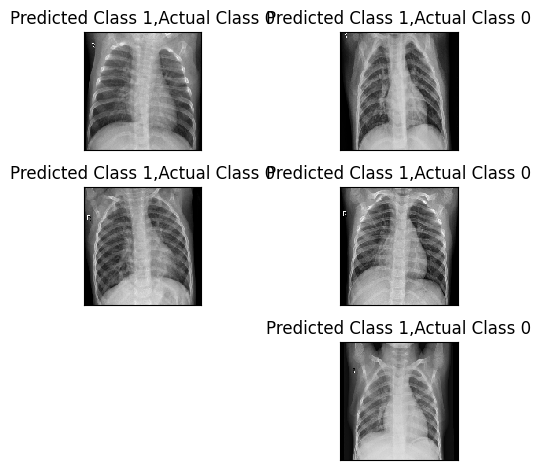

In [ ]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3, 2, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[c].reshape(150, 150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1